In [1]:
import tensorflow as tf, cv2, numpy as np, PIL, matplotlib
print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))
print("OpenCV:", cv2.__version__)
print("NumPy:", np.__version__)
print("Pillow:", PIL.__version__)
print("Matplotlib:", matplotlib.__version__)



TF: 2.15.0
GPU: []
OpenCV: 4.11.0
NumPy: 1.26.4
Pillow: 11.3.0
Matplotlib: 3.9.4


In [2]:
from pathlib import Path
PROJECT_ROOT = Path(r"C:\Users\Saeid_Eshghi\Project_7")
DATA_ROOT    = PROJECT_ROOT / "dataset"

OUT_ROOT = PROJECT_ROOT / "out"
CKPT     = OUT_ROOT / "checkpoints"
REPORTS  = OUT_ROOT / "reports"
for p in [OUT_ROOT, CKPT, REPORTS]: p.mkdir(parents=True, exist_ok=True)

CLASSES = ["cardboard","glass","metal","paper","plastic","trash"]
print("DATA:", DATA_ROOT, "| exists:", DATA_ROOT.exists())


DATA: C:\Users\Saeid_Eshghi\Project_7\dataset | exists: True


In [3]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

exts = (".jpg",".jpeg",".png",".bmp",".webp")
paths, y = [], []
for i,c in enumerate(CLASSES):
    for p in (DATA_ROOT/c).rglob("*"):
        if p.suffix.lower() in exts:
            paths.append(str(p))
            y.append(i)
paths, y = np.array(paths), np.array(y)
print("Total images:", len(paths))

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)  # 70% train
(train_idx, temp_idx) = next(sss1.split(paths, y))
X_train, y_train = paths[train_idx], y[train_idx]
X_temp,  y_temp  = paths[temp_idx],  y[temp_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=42)  # 15/15
(val_idx, test_idx) = next(sss2.split(X_temp, y_temp))
X_val,  y_val  = X_temp[val_idx],  y_temp[val_idx]
X_test, y_test = X_temp[test_idx], y_temp[test_idx]

print(f"Split → train={len(X_train)} | val={len(X_val)} | test={len(X_test)}")


Total images: 2527
Split → train=1768 | val=379 | test=380


In [4]:
import tensorflow as tf
IMG_SIZE = 224
BATCH    = 32
AUTO     = tf.data.AUTOTUNE

def load_img(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), antialias=True)
    img = tf.cast(img, tf.float32)/255.0
    return img, tf.one_hot(label, depth=len(CLASSES))

augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.12),
    tf.keras.layers.RandomContrast(0.12),
    tf.keras.layers.GaussianNoise(0.02),
], name="aug")

def make_ds(files, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((files,labels))
    if training: ds = ds.shuffle(4096, seed=123, reshuffle_each_iteration=True)
    ds = ds.map(load_img, num_parallel_calls=AUTO)
    if training: ds = ds.map(lambda x,y: (augment(x, training=True), y), num_parallel_calls=AUTO)
    ds = ds.batch(BATCH).prefetch(AUTO)
    return ds

train_ds = make_ds(X_train, y_train, training=True)
val_ds   = make_ds(X_val,   y_val,   training=False)
test_ds  = make_ds(X_test,  y_test,  training=False)

for xb,yb in train_ds.take(1):
    print("Batch:", xb.shape, yb.shape, xb.dtype)



Batch: (32, 224, 224, 3) (32, 6) <dtype: 'float32'>


In [5]:
from collections import Counter
cnt = Counter(y_train.tolist())
N = sum(cnt.values())
class_weights = {i: N/(len(CLASSES)*cnt.get(i,1)) for i in range(len(CLASSES))}
print("class_weights:", {k: round(v,3) for k,v in class_weights.items()})


class_weights: {0: 1.045, 1: 0.842, 2: 1.027, 3: 0.708, 4: 0.874, 5: 3.069}


In [6]:
from tensorflow.keras import layers, Model

def build_model(img_size=IMG_SIZE, num_classes=len(CLASSES), dropout=0.3, label_smooth=0.05):
    base = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(img_size,img_size,3), weights="imagenet")
    base.trainable = False  # Stage-1
    inp = layers.Input(shape=(img_size,img_size,3))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inp*255.0)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = Model(inp, out, name="trash_mobilenetv2")
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smooth)
    model.compile(optimizer=tf.keras.optimizers.Adam(8e-4), loss=loss, metrics=["accuracy"])
    return model, base

model, backbone = build_model()
model.summary()



Model: "trash_mobilenetv2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.multiply (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                        

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
BEST = CKPT / "best.keras"
cbs = [
    ModelCheckpoint(str(BEST), monitor="val_loss", mode="min", save_best_only=True),
    EarlyStopping(monitor="val_loss", mode="min", patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    CSVLogger(str(REPORTS/"train_log.csv"))
]


In [8]:
E1 = 5
hist1 = model.fit(train_ds, validation_data=val_ds, epochs=E1, class_weight=class_weights, callbacks=cbs, verbose=1)


Epoch 1/5


56/56 [==============================] - 35s 579ms/step - loss: 1.6214 - accuracy: 0.3976 - val_loss: 1.1029 - val_accuracy: 0.6095 - lr: 8.0000e-04
Epoch 2/5
56/56 [==============================] - 31s 557ms/step - loss: 1.1386 - accuracy: 0.6109 - val_loss: 0.9957 - val_accuracy: 0.6675 - lr: 8.0000e-04
Epoch 3/5
56/56 [==============================] - 32s 562ms/step - loss: 1.0101 - accuracy: 0.6736 - val_loss: 0.9083 - val_accuracy: 0.7124 - lr: 8.0000e-04
Epoch 4/5
56/56 [==============================] - 32s 565ms/step - loss: 0.9061 - accuracy: 0.7115 - val_loss: 0.8499 - val_accuracy: 0.7361 - lr: 8.0000e-04
Epoch 5/5
56/56 [==============================] - 32s 570ms/step - loss: 0.8696 - accuracy: 0.7330 - val_loss: 0.8183 - val_accuracy: 0.7388 - lr: 8.0000e-04


In [9]:
def unfreeze_last_layers(backbone, n=80):
    opened=0
    for l in reversed(backbone.layers):
        if isinstance(l, tf.keras.layers.BatchNormalization): 
            continue
        l.trainable = True
        opened+=1
        if opened>=n: break
    print("Unfrozen (non-BN):", opened)

unfreeze_last_layers(backbone, n=80)

# LR کوچک‌تر برای FT
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
model.compile(optimizer=tf.keras.optimizers.Adam(2e-4), loss=loss, metrics=["accuracy"])
E2 = 18
hist2 = model.fit(train_ds, validation_data=val_ds, epochs=E2, class_weight=class_weights, callbacks=cbs, verbose=1)
print("Best saved:", BEST)


Unfrozen (non-BN): 80
Epoch 1/18
56/56 [==============================] - 35s 576ms/step - loss: 0.7971 - accuracy: 0.7675 - val_loss: 0.8018 - val_accuracy: 0.7625 - lr: 2.0000e-04
Epoch 2/18
56/56 [==============================] - 32s 569ms/step - loss: 0.7748 - accuracy: 0.7675 - val_loss: 0.7980 - val_accuracy: 0.7652 - lr: 2.0000e-04
Epoch 3/18
56/56 [==============================] - 31s 554ms/step - loss: 0.7522 - accuracy: 0.7845 - val_loss: 0.8001 - val_accuracy: 0.7704 - lr: 2.0000e-04
Epoch 4/18
56/56 [==============================] - 32s 572ms/step - loss: 0.7748 - accuracy: 0.7822 - val_loss: 0.7858 - val_accuracy: 0.7652 - lr: 2.0000e-04
Epoch 5/18
56/56 [==============================] - 32s 571ms/step - loss: 0.7757 - accuracy: 0.7845 - val_loss: 0.7818 - val_accuracy: 0.7757 - lr: 2.0000e-04
Epoch 6/18
56/56 [==============================] - 32s 571ms/step - loss: 0.7703 - accuracy: 0.7845 - val_loss: 0.7856 - val_accuracy: 0.7678 - lr: 2.0000e-04
Epoch 7/18
56/56 [

In [10]:
tf.keras.backend.clear_session()
clean_model = tf.keras.models.load_model(BEST)
print("Loaded:", BEST)
test_metrics = clean_model.evaluate(test_ds, return_dict=True)
print("TEST:", test_metrics)


Loaded: C:\Users\Saeid_Eshghi\Project_7\out\checkpoints\best.keras
12/12 [==============================] - 6s 425ms/step - loss: 0.7433 - accuracy: 0.7842
TEST: {'loss': 0.7432891130447388, 'accuracy': 0.7842105031013489}


In [11]:
import numpy as np, json
from sklearn.metrics import classification_report

y_true, y_prob = [], []
for xb,yb in test_ds:
    y_true.append(yb.numpy())
    y_prob.append(clean_model.predict(xb, verbose=0))
y_true = np.concatenate(y_true); y_prob = np.concatenate(y_prob)
y_pred = np.argmax(y_prob,1); y_true_idx = np.argmax(y_true,1)

rep = classification_report(y_true_idx, y_pred, target_names=CLASSES, output_dict=True)
print(classification_report(y_true_idx, y_pred, target_names=CLASSES))

(REPORTS/"classification_report.json").write_text(json.dumps(rep, ensure_ascii=False, indent=2), encoding="utf-8")
print("Saved:", REPORTS/"classification_report.json")


              precision    recall  f1-score   support

   cardboard       0.88      0.83      0.85        60
       glass       0.83      0.66      0.74        76
       metal       0.72      0.76      0.74        62
       paper       0.80      0.88      0.84        89
     plastic       0.76      0.84      0.80        73
       trash       0.57      0.60      0.59        20

    accuracy                           0.78       380
   macro avg       0.76      0.76      0.76       380
weighted avg       0.79      0.78      0.78       380

Saved: C:\Users\Saeid_Eshghi\Project_7\out\reports\classification_report.json


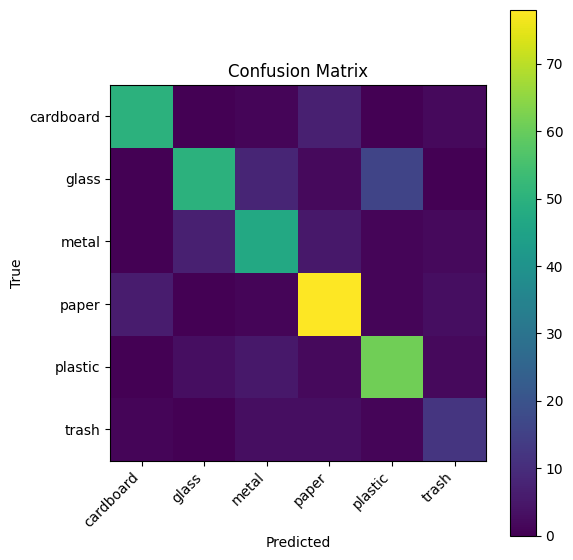

Saved: C:\Users\Saeid_Eshghi\Project_7\out\reports\confusion_matrix.png


In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_idx, y_pred, labels=list(range(len(CLASSES))))
fig = plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(CLASSES)), CLASSES, rotation=45, ha='right')
plt.yticks(range(len(CLASSES)), CLASSES)
plt.colorbar(); plt.tight_layout()
fig_path = REPORTS / "confusion_matrix.png"
plt.savefig(fig_path, dpi=150, bbox_inches='tight'); plt.show()
print("Saved:", fig_path)


In [13]:
# Keras (final copy)
FINAL = CKPT / "final.keras"
clean_model.save(FINAL, save_format="keras")
print("Saved Keras:", FINAL)

# TFLite FP32
converter = tf.lite.TFLiteConverter.from_keras_model(clean_model)
tfl32 = converter.convert()
(OUT_ROOT/"trash_mobilenetv2_fp32.tflite").write_bytes(tfl32)

# TFLite FP16
converter = tf.lite.TFLiteConverter.from_keras_model(clean_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tfl16 = converter.convert()
(OUT_ROOT/"trash_mobilenetv2_fp16.tflite").write_bytes(tfl16)
print("Saved TFLite fp32/fp16 in:", OUT_ROOT)

# ذخیره‌ی کلاس‌ها
import json
(OUT_ROOT/"classes.json").write_text(json.dumps(CLASSES, ensure_ascii=False, indent=2), encoding="utf-8")


Saved Keras: C:\Users\Saeid_Eshghi\Project_7\out\checkpoints\final.keras
INFO:tensorflow:Assets written to: C:\Users\SAEID_~1\AppData\Local\Temp\tmpibxdgyhb\assets


INFO:tensorflow:Assets written to: C:\Users\SAEID_~1\AppData\Local\Temp\tmpibxdgyhb\assets


INFO:tensorflow:Assets written to: C:\Users\SAEID_~1\AppData\Local\Temp\tmpsfl0iz6_\assets


INFO:tensorflow:Assets written to: C:\Users\SAEID_~1\AppData\Local\Temp\tmpsfl0iz6_\assets


Saved TFLite fp32/fp16 in: C:\Users\Saeid_Eshghi\Project_7\out


74

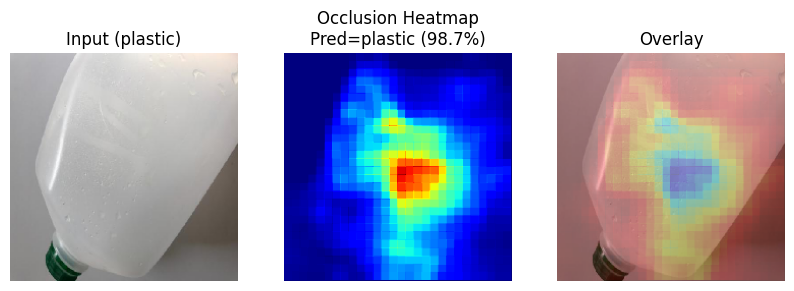

In [17]:
import numpy as np, cv2, matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random

IMG_SIZE=224; PATCH=15; STRIDE=8; FILL=0.0

def occlusion_heatmap(model, img_float01, target_idx=None, patch=PATCH, stride=STRIDE, fill=FILL):
    H,W,_ = img_float01.shape
    base = model.predict(np.expand_dims(img_float01,0), verbose=0)[0]
    if target_idx is None:
        target_idx = int(np.argmax(base))
    base_conf = float(base[target_idx])

    heat = np.zeros((H,W), np.float32); counts = np.zeros((H,W), np.float32)
    for y in range(0, H-patch+1, stride):
        for x in range(0, W-patch+1, stride):
            im2 = img_float01.copy()
            im2[y:y+patch, x:x+patch] = fill
            prob = model.predict(np.expand_dims(im2,0), verbose=0)[0]
            drop = base_conf - float(prob[target_idx])
            heat[y:y+patch, x:x+patch] += drop
            counts[y:y+patch, x:x+patch] += 1
    heat /= (counts+1e-8); heat = np.maximum(heat,0); heat /= (heat.max()+1e-8)
    return heat, target_idx, base_conf

def show_occlusion_sample():
    cls = random.choice(CLASSES)
    files = [p for p in (DATA_ROOT/cls).rglob("*") if p.suffix.lower() in (".jpg",".jpeg",".png",".bmp",".webp")]
    sample = random.choice(files)
    img = image.load_img(sample, target_size=(IMG_SIZE,IMG_SIZE))
    x_u8 = image.img_to_array(img).astype("uint8")
    x = x_u8.astype("float32")/255.0

    heat, idx, conf = occlusion_heatmap(clean_model, x)
    pred = CLASSES[idx]
    hm_u8 = np.uint8(255*cv2.resize(heat,(IMG_SIZE,IMG_SIZE)))
    hm_color = cv2.applyColorMap(hm_u8, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(x_u8, 0.7, hm_color, 0.3, 0)

    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1); plt.imshow(x_u8); plt.title(f"Input ({cls})"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(heat, cmap="jet"); plt.title(f"Occlusion Heatmap\nPred={pred} ({conf*100:.1f}%)"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
    plt.show()

show_occlusion_sample()


In [15]:
tf.keras.backend.clear_session()
from tensorflow.keras import layers, Model

def rebuild_architecture():
    base = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(224,224,3), weights=None)
    inp = layers.Input(shape=(224,224,3))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inp*255.0)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(len(CLASSES), activation="softmax")(x)
    m = Model(inp, out, name="trash_gradcam_model")
    return m, base

fresh_model, base = rebuild_architecture()
fresh_model.set_weights(clean_model.get_weights())
print("fresh_model ready. backbone name:", base.name)  # معمولاً mobilenetv2_1.00_224


fresh_model ready. backbone name: mobilenetv2_1.00_224


In [1]:
from pathlib import Path
import tensorflow as tf

PROJECT_ROOT = Path(r"C:\Users\Saeid_Eshghi\Project_7")
OUT = PROJECT_ROOT / "out"
CKPT = OUT / "checkpoints"
EXPORT = OUT / "exports"
EXPORT.mkdir(parents=True, exist_ok=True)

model = tf.keras.models.load_model(CKPT / "best.keras")

# 1) ذخیره نسخه Keras (همین الان داری)
model.save(EXPORT / "best.keras")

# 2) ذخیره SavedModel (برای تبدیل به ONNX)
tf.saved_model.save(model, str(EXPORT / "saved_model"))
print("Saved:", EXPORT)


INFO:tensorflow:Assets written to: C:\Users\Saeid_Eshghi\Project_7\out\exports\saved_model\assets


INFO:tensorflow:Assets written to: C:\Users\Saeid_Eshghi\Project_7\out\exports\saved_model\assets


Saved: C:\Users\Saeid_Eshghi\Project_7\out\exports
